In [1]:
# import logging
import os
import re
from pathlib import Path
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import torch
import yaml
from einops import rearrange

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from mushroom.mushroom import Mushroom
import mushroom.data.xenium as xenium
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils

/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()


In [5]:
run_dir = '/data/estorrs/mushroom/data/projects/xenium_grant'
mushroom_dir = os.path.join(run_dir, 'mushroom')
config_fps = sorted(utils.listfiles(mushroom_dir, regex=r'/config.yaml'))
config_fps

['/data/estorrs/mushroom/data/projects/xenium_grant/mushroom/HT206B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/xenium_grant/mushroom/S18-9906/config.yaml']

In [6]:
# only relavent for dinglab data since our channel names are all over the place
# will remove for official example
official_to_options = {
    'Pan-Cytokeratin': ['Pan-Cytokeratin', 'Pan-CK', 'Pan-CK (D)', 'PanCK (D)'],
    'E-cadherin': ['E-cadherin'],
    'CD45': ['CD45 (D)', 'CD45', 'CD45-(D)', 'CD45(D)'],
    'CD45RO': ['CD45RO'],
    'CD45RA': ['CD45RA'],
    'CD8': ['CD8', 'CD8a'],
    'DAPI': ['DAPI'],
    'CD4': ['CD4', 'CD4 (D)'],
    'CD3e': ['CD3e', 'CD3'],
    'Vimentin': ['Vimentin-(D)', 'Vimentin', 'Vimentin (D)'],
    'SMA': ['SMA-(D)', 'SMA', 'SMA (D)', 'a-SMA (D)'],
    'CD31': ['CD31', 'CD31-(D)', 'CD31 (D)'],
    'CD20': ['CD20-(D)', 'CD20', 'CD20 (D)', 'CD20-Akoya'],
    'CD68': ['CD68', 'CD68 (D)', 'CD68-(D)'],
    'CD163': ['CD163'],
    'FOXP3': ['FoxP3', 'FOXP3', 'Foxp3'],
    'cKit': ['cKIT (D)', 'cKit (D)', 'cKit', 'cKIT', 'cKIT-(D)'],
    'MGP': ['MGP', 'MGP (D)', 'MGP-(D)'],
    'CD36': ['CD36-(D)', 'CD36'],
    'PR': ['PR', 'PR-(D)', 'PR (D)'],
    'ER': ['ER', 'ER-(D)', 'ER (D)'],
    'P21': ['P21', 'P21-(D)', 'P21-(D)', 'P21 (D)'],
    'P16': ['P16-(D)'],
    'CK5': ['Keratin 5', 'KRT5'],
    'TFF1': ['TFF1', 'TFF1-(D)', 'TFF1 (D)'],
    'beta-integrin': ['beta-integrin', 'beta3-integrin'],
    'CK14': ['CK14', 'Keratin 14', 'CK14 (D)'],
    'CK17': ['CK17', 'CK17 (D)', 'CK17-(D)', 'Keratin 17'],
    'CK19': ['CK19', 'CK19 (D)', 'CK19-(D)'],
    'CD11b': ['CD11b', 'CD11b (D)', 'CD11b-(D)'],
    'GATA3': ['GATA3', 'GATA3-(D)', 'GATA3 (D)'],
    'PLAT/tPA': ['PLAT/tPA', 'PLAT/tPA (D)'],
    'COX6c': ['COX6c (D)'],
    'Her2': ['Her2', 'Her2 (D)'],
    'Bap1': ['Bap1 (D)'],
    'GLUT1': ['Glut1', 'GLUT1', 'GLUT1-(D)', 'GLUT1 (D)'],
    'CD11c': ['CD11c'],
    'HLA-DR': ['HLA-DR'],
    'Ki67': ['Ki67', 'KI67'],
    'Podoplanin': ['Podoplanin', 'PDPN', 'Podoplanin (D)'],
    'CTLA4': ['CTLA4', 'CTLA4 (D)', 'CTLA4-(D)'],
    'SLC39A6': ['SLC39A6'],
    'BCA1': ['BCA1'],
    'BCAL': ['BCAL'],
    'TUBB3': ['TUBB3', 'TUBB3 (D)'],
    'PTPRZ1': ['PTPRZ1', 'PTPRZ1 (D)'],
    'HIF1A': ['HIF1a', 'HIF1a (D)', 'HIF1A'],
    'PAI1': ['PAI1', 'PAI1-(D)'],
    'GFAP': ['GFAP', 'GFAP (D)'],
    'VEGFA': ['VEGFA', 'VEGFA (D)'],
    'IBA1': ['IBA1', 'IBA1 (D)'],
    'OLIG2': ['OLIG2', 'OLIG2 (D)'],
    'FN1': ['FN1', 'FN1 (D)'],
    'a-Amylase': ['a-Amylase'],
    'Hep-Par-1': ['Hep-Par-1 (D)'],
    'Granzyme-B': ['Granzyme B'],
    'TCF-1': ['TCF-1'],
    'CD39': ['CD39'],
    'PD1': ['PD-1'],
    'PDL1': ['PD-L1'],
    'Histone-H3-Pho': ['Histone H3 Pho'],
    'Maspin': ['Maspin'],
    'MMP9': ['MMP9'],
    'CD44': ['CD44'],
    'CD107A': ['CD107a'],
    'FGFR3': ['FGFR3'],
    'CD138': ['CD138'],
    'MLPH': ['MLPH'],
    'P63': ['P63'],
    'GP2': ['GP2'],
    'COX2': ['COX2'],
    'Lyve-1': ['Lyve-1'],
}
channel_mapping = {v:k for k, vs in official_to_options.items() for v in vs}
# channel_mapping = None

In [7]:
xenium_config = {
    'dtype': 'multiplex',
#     'sections': config,
    'chkpt_filepath': None,
    'sae_kwargs': {
        'size': 256,
        'patch_size': 32,
        'encoder_dim': 256,
        'kl_scaler': 0.,
        'recon_scaler': 1.,
        'neigh_scaler': 0.,
        'codebook_size': 30,
        'decoder_dims': (256, 50, 50,)
    },
    'learner_kwargs': {
        'scale': .5,
        'contrast_pct': None,
#         'pct_expression': .02,
        'batch_size': 64,
        'num_workers': 1,
        'device': 'cpu',
#         'channels': channels,
        'channel_mapping': channel_mapping
    },
    'train_kwargs': {
        'num_iters': 1000,
        'lr': 1e-4,
        'log_every': 10,
        'save_every': 100,
#         'save_dir': chkpt_dir       
    },
}

In [8]:
config_fp = '/data/estorrs/mushroom/data/projects/xenium_grant/mushroom/S18-9906/config.yaml'

case = config_fp.split('/')[-2]
out_dir = os.path.join(f'/data/estorrs/mushroom/data/projects/xenium_grant/mushroom/{case}_codex/outputs')

config = yaml.safe_load(open(config_fp))

chkpt_dir = os.path.join(out_dir, 'chkpts')
Path(chkpt_dir).mkdir(parents=True, exist_ok=True)

In [17]:
xenium_config['sections'] = config
xenium_config['train_kwargs']['save_dir'] = chkpt_dir
xenium_config['chkpt_filepath'] = os.path.join(chkpt_dir, '500iter.pt')

In [18]:
mushroom = Mushroom.from_config(xenium_config)

INFO:root:using device: cpu
INFO:root:generating inputs for multiplex tissue sections
INFO:root:using 24 channels
INFO:root:4 sections detected: ['s1', 's3', 's5', 's7']
INFO:root:processing sections
INFO:root:generating image data for section s1
INFO:root:generating image data for section s3
INFO:root:generating image data for section s5
INFO:root:generating image data for section s7
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:learner initialized


In [19]:
mushroom.embed_sections()

array([[<Axes: title={'center': 's1'}, ylabel='predicted'>,
        <Axes: title={'center': 's3'}>, <Axes: title={'center': 's5'}>,
        <Axes: title={'center': 's7'}>],
       [<Axes: ylabel='true'>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

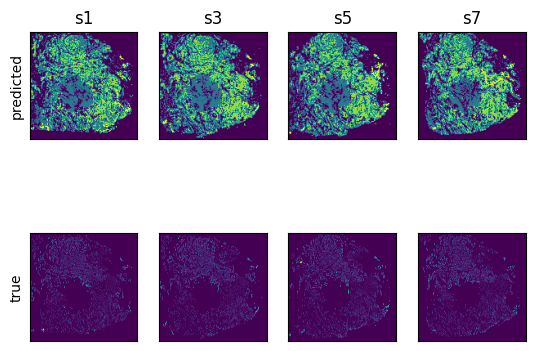

In [20]:
mushroom.display_predicted_pixels(channel='Pan-Cytokeratin')

array([[<Axes: title={'center': 's1'}, ylabel='predicted'>,
        <Axes: title={'center': 's3'}>, <Axes: title={'center': 's5'}>,
        <Axes: title={'center': 's7'}>],
       [<Axes: ylabel='true'>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

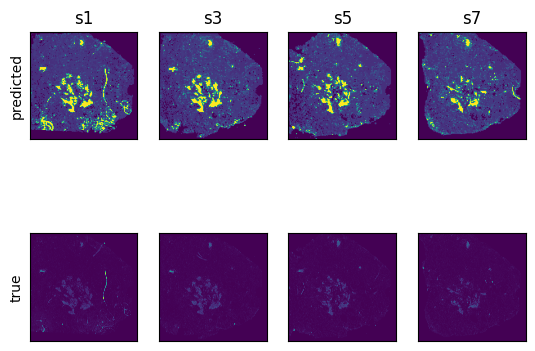

In [21]:
mushroom.display_predicted_pixels(channel='CD4')

In [22]:
cluster_ids = mushroom.cluster_ids.cpu().detach().numpy()

In [23]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 14 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 14 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 2

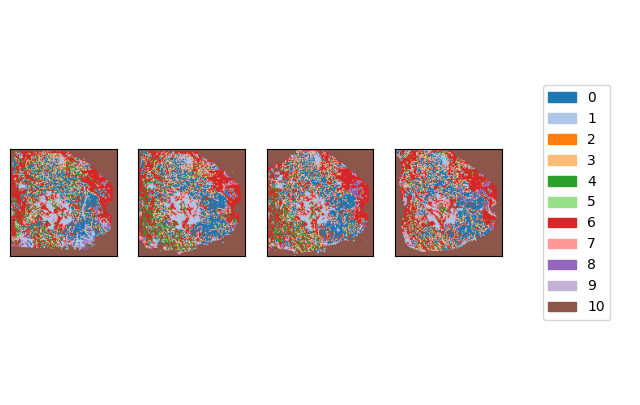

In [24]:
vis_utils.display_clusters(cluster_ids)
plt.savefig(os.path.join(out_dir, 'codex_neighborhoods.pdf'))

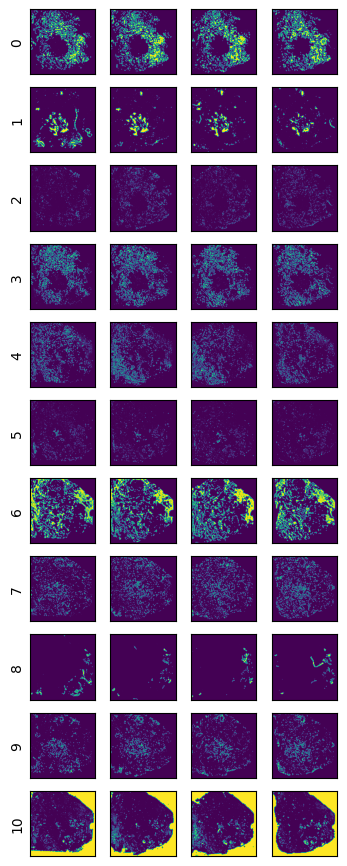

In [25]:
utils.display_cluster_probs(mushroom.cluster_probs)

In [18]:
# S18-9906	S18-9906-U2	xenium	0	0 
# S18-9906	S18-9906-U3	multiplex	1	5
# S18-9906	S18-9906-U9	xenium	2	35
# S18-9906	S18-9906-U10	multiplex	3	40
# S18-9906	S18-9906-U17	xenium	4	75
# S18-9906	S18-9906-U18	multiplex	5	80
# S18-9906	S18-9906-U24	xenium	6	110
# S18-9906	S18-9906-U25	multiplex	7	115

In [26]:
section_positions = (np.asarray([0, 35, 75, 110]) * .1).astype(int)
print(section_positions)
cluster_volume = utils.get_interpolated_volume(cluster_ids, section_positions)
cluster_volume.shape

[ 0  3  7 11]


(11, 132, 132)

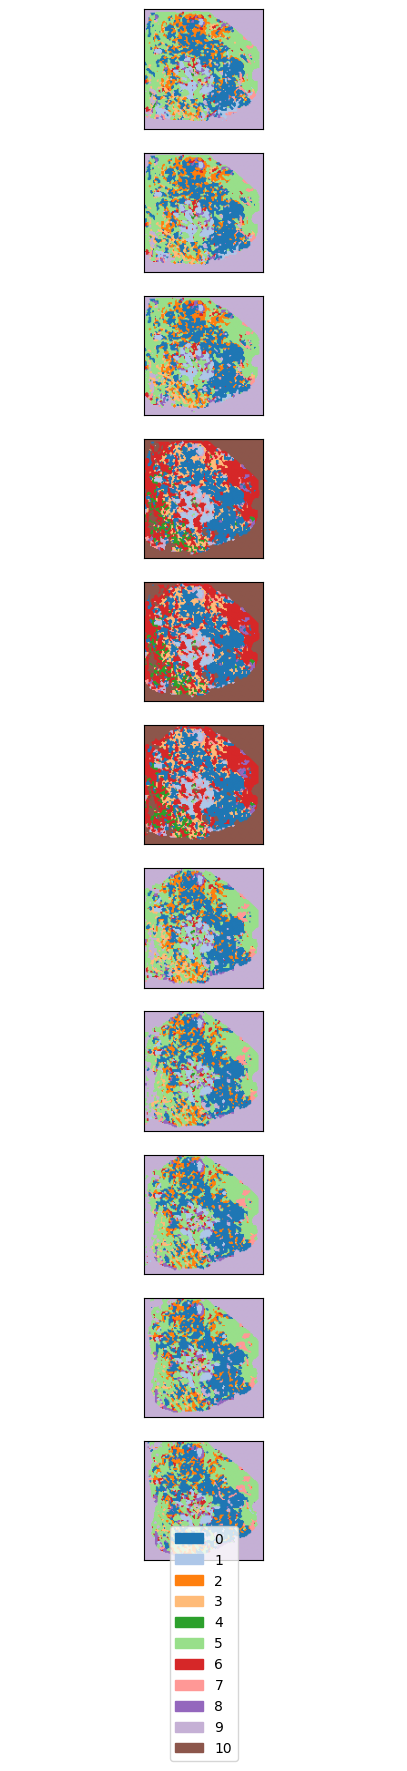

In [27]:
vis_utils.display_clusters(cluster_volume, horizontal=False)

In [28]:
probs = rearrange(mushroom.cluster_probs, 'n c h w -> c n h w').cpu().detach().numpy()
probs_volume = utils.get_interpolated_volume(probs, section_positions, method='linear')

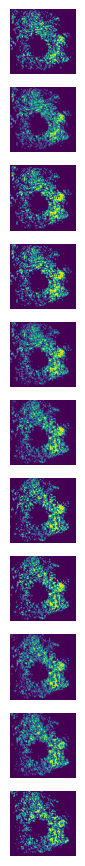

In [29]:
fig, axs = plt.subplots(nrows=probs_volume.shape[1], figsize=(5, probs_volume.shape[1]))
for i, ax in enumerate(axs):
    ax.imshow(probs_volume[0, i])
    ax.axis('off')
    

In [30]:
out_fp = os.path.join(out_dir, 'outputs.npy')
np.save(out_fp, {
    'cluster_ids': cluster_ids,
    'cluster_probs': probs,
    'cluster_volume': cluster_volume,
    'section_positions': section_positions
})


In [31]:
out_fp

'/data/estorrs/mushroom/data/projects/xenium_grant/mushroom/S18-9906_codex/outputs/outputs.npy'

In [32]:
cluster_df = mushroom.get_cluster_intensities(cluster_ids)
cluster_df

,AMACR,AR,CD20,CD31,CD3e,CD4,CD45,CD68,CD8,CK14,...,FOXP3,HLA-DR,Ki67,LYVE1,Pan-Cytokeratin,Podoplanin,SMA,STEAP4,Vimentin,p63
0,-0.021765,0.362528,0.108815,0.087481,0.027899,0.045667,0.006570,0.508448,0.038867,-0.005117,...,0.025596,0.103258,0.074462,0.315001,0.713307,0.018208,-0.483342,0.119923,0.042056,0.037981
1,0.934648,0.951322,0.939660,0.947703,0.937435,0.938821,0.942998,0.947806,0.668597,-0.021126,...,0.794898,0.937413,0.937906,0.953821,0.192349,0.807482,-0.061074,0.943229,0.948457,0.233791
2,0.129820,0.362124,0.212786,0.296082,0.164154,0.158594,0.221477,0.308466,0.264058,0.173340,...,0.238970,0.123027,0.166684,0.390830,0.457393,0.240424,0.082680,0.266020,0.313956,0.180745
3,-0.008935,0.280686,0.078500,0.171275,0.033193,0.043801,0.072386,0.220883,0.021321,0.004178,...,-0.022749,0.066637,0.030123,0.216904,0.378314,-0.006171,-0.017062,0.097790,0.141143,-0.018896
4,-0.065614,0.044220,-0.015767,0.064496,-0.012503,-0.002837,0.057867,-0.063830,-0.060805,-0.023885,...,-0.073548,-0.016170,-0.059205,0.026723,-0.055357,-0.058455,0.327444,-0.019960,0.076716,-0.048621
5,-0.037890,0.039894,-0.011117,0.046224,0.004743,0.011629,-0.017653,0.064961,-0.022528,-0.017413,...,-0.077017,0.002198,0.002378,0.030163,0.094844,-0.069459,-0.152737,0.073347,0.010509,-0.029063
6,-0.078577,-0.092034,-0.043397,-0.009112,-0.011231,-0.002514,0.134726,-0.221270,-0.077057,-0.027548,...,-0.077021,-0.071998,-0.072184,-0.002380,-0.356427,-0.044754,0.890627,-0.092725,0.068256,-0.035276
7,0.025448,0.140903,0.077244,0.253526,0.091745,0.108469,0.211780,0.007063,0.040271,-0.013657,...,-0.033285,0.071232,0.047522,0.202013,-0.041116,0.004921,0.557448,0.064797,0.268567,-0.031935
8,0.120877,0.413626,0.349590,0.369165,0.168899,0.084839,0.255712,0.289192,0.843957,0.830526,...,0.838833,-0.070782,0.239484,0.577478,0.881106,0.839395,0.183161,0.393139,0.475136,0.833763
9,0.223628,0.375156,0.260608,0.410549,0.256675,0.276783,0.352711,0.268862,0.187334,0.016895,...,0.192937,0.244260,0.242573,0.420133,0.187465,0.165347,0.308657,0.307491,0.428112,0.027388


In [33]:
cluster_df.columns

Index(['AMACR', 'AR', 'CD20', 'CD31', 'CD3e', 'CD4', 'CD45', 'CD68', 'CD8',
       'CK14', 'CK5', 'CK7', 'DAPI', 'E-Cadherin', 'FOXP3', 'HLA-DR', 'Ki67',
       'LYVE1', 'Pan-Cytokeratin', 'Podoplanin', 'SMA', 'STEAP4', 'Vimentin',
       'p63'],
      dtype='object')

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 38 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'C', 'D', 'E', 'K', 'M', 'P', 'S', 'a', 'd', 'e', 'eight', 'five', 'four', 'h', 'hyphen', 'i', 'k', 'l', 'minus', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 'seven', 'six', 'space', 't', 'three', 'two', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 36, 38, 39, 40, 46, 48, 51, 54, 68, 71, 72, 75, 76, 78, 79, 81, 82, 83, 85, 87, 92, 3228]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 38 glyphs after
IN

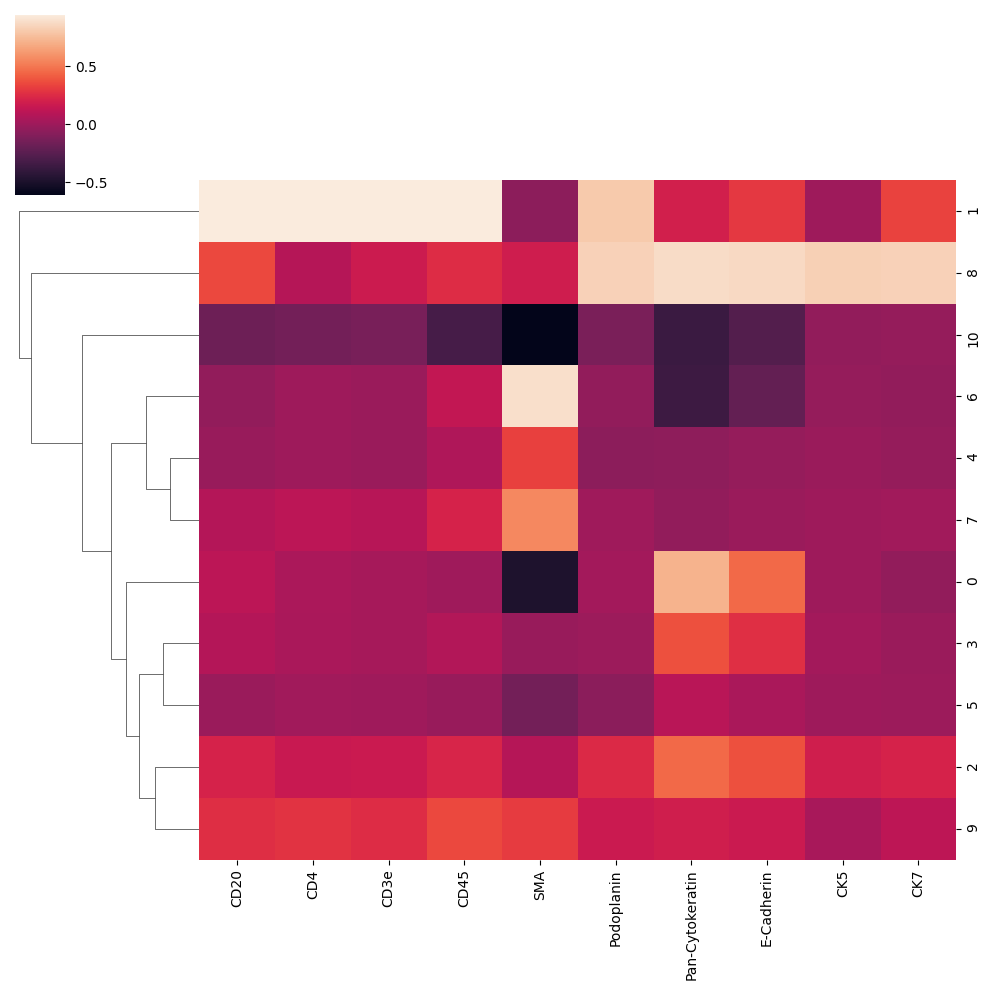

In [37]:
sns.clustermap(
    cluster_df[['CD20', 'CD4', 'CD3e', 'CD45', 'SMA', 'Podoplanin', 'Pan-Cytokeratin', 'E-Cadherin', 'CK5', 'CK7']],
    row_cluster=True, col_cluster=False
)
plt.savefig(os.path.join(out_dir, 'codex_genes_heatmap.pdf'))

In [35]:
out_dir

'/data/estorrs/mushroom/data/projects/xenium_grant/mushroom/S18-9906_codex/outputs'

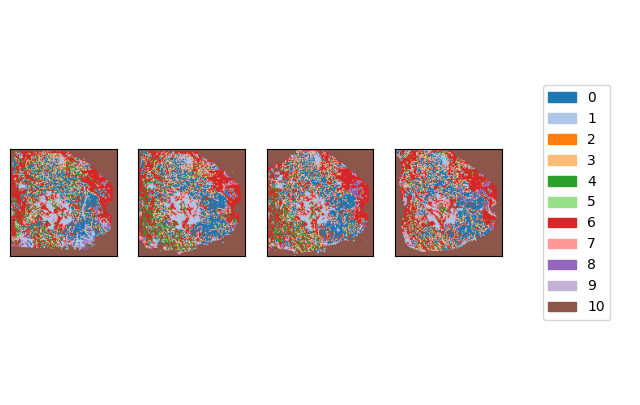

In [36]:
vis_utils.display_clusters(cluster_ids)

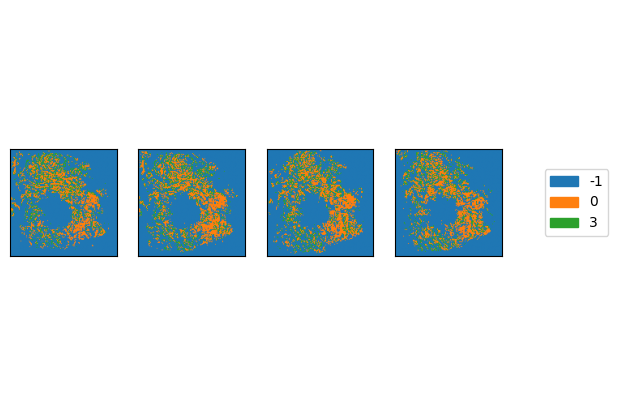

In [38]:
groups = [0,3] 

vis_utils.show_groups(cluster_ids, groups)